In [2]:
import numpy as np
import matplotlib.pyplot as plt

def linear(x, slope, intercept):
    return slope*x + intercept

def logit(p):
    return np.log(p/(1-p))

def inv_logit(alpha):
    return np.exp(alpha)/(np.exp(alpha)+1)

def logistic(x, beta_0, beta_1):
    return inv_logit(linear(x, beta_0, beta_1))



In [11]:
# Linear Regression example
model = linear
param_count = 2
step_size = 2**-12
differential_length = 2**-16
epoch_count = 2**14

def squared_error(params, x, y):
    squared_error = (model(x, *params) - y)**2
    return squared_error

def surprisal(params, x, y):
    prob = model(x, *params)
    if y:
        return -np.log(prob)
    else:
        return -np.log(1-prob)


loss = squared_error

xdata = np.array([0, 1, 2])
ydata = np.array([0, 1.5, 2])

In [4]:
# Calculate the gradient of vector feld f at v
def gradient(f, v):
    n = len(v)
    grad = np.zeros(n)
    for i in range(len(v)):
        d = np.zeros(n)
        d[i] = differential_length
        directional_derivative = (f(v+d/2) - f(v-d/2))/differential_length
        grad[i] = directional_derivative
    return grad

In [5]:
def descent_step(params, x, y, weight):
    f = lambda theta: loss(theta, x, y)
    grad = gradient(f, params)
    params = params - weight*grad*step_size
    return params


def epoch(params, xdata, ydata, weights):
    for i in range(len(xdata)):
        params = descent_step(params, xdata[i], ydata[i], weights[i])
    return params

def gradient_descent(params, xdata, ydata, weights):
    for _ in range(epoch_count):
        params = epoch(params, xdata, ydata, weights)
    return params

This function calculates the parameters which result from retraining with an additional datapoint *new* that is weighted by some amount *epsilon*.

In [6]:
# Influence functions are defined as the first-order Taylor approximation of this around epsilon = 0
# Or maybe the derivative if it's more convenient to subtract off the value at 0, I think I've seen both definitions
def response_function(new_data, epsilon, xdata, ydata):
    newxdata = np.concatenate((np.array([new_data[0]]), xdata))
    newydata = np.concatenate((np.array([new_data[1]]), ydata))
    weights = np.array([epsilon] + [1 for _ in xdata])
    params = gradient_descent(np.zeros(param_count), newxdata, newydata, weights)
    return params

In [7]:
def influence(z, epsilon):
    a = response_function(z, epsilon/2, xdata, ydata)
    b = response_function(z, -epsilon/2, xdata, ydata)
    return (a-b)/epsilon

Initial model: [0.99947459 0.16720853]
[ 0.08480315 -0.14103327]
[8.76885160e-05 1.10722232e-01]
[-0.08253084  0.02722104]


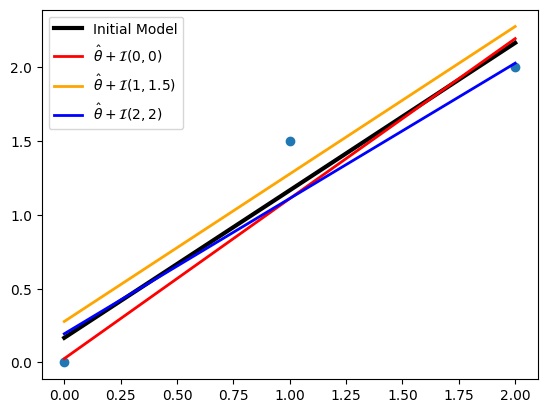

In [16]:
epsilon = 0.001
delta = 1
z1 = (0,0)
z2 = (1,1.5)
z3 = (2,2)
y = response_function(z1, 0, xdata, ydata)
print(f'Initial model: {y}')
influence1 = influence(z1, epsilon)
influence2 = influence(z2, epsilon)
influence3 = influence(z3, epsilon)
linspace = np.linspace(xdata.min(), xdata.max(), 500)

x1 = y + influence1*delta
x2 = y + influence2*delta
x3 = y + influence3*delta

print(influence1)
print(influence2)
print(influence3)

plt.plot(linspace, model(linspace, *y), color='black',linewidth=3, label="Initial Model")
plt.plot(linspace, model(linspace, *x1), color='red',linewidth=2, label=f"$\hat\\theta + \mathcal{{I}}(0,0)$")
plt.plot(linspace, model(linspace, *x2), color='orange',linewidth=2, label=f"$\hat\\theta + \mathcal{{I}}(1,1.5)$")
plt.plot(linspace, model(linspace, *x3), color='blue',linewidth=2, label=f"$\hat\\theta + \mathcal{{I}}(2,2)$")
plt.scatter(xdata,ydata)
plt.legend()
plt.show()

In [17]:
# Takes a function f:R^n -> R^m and returns an
# m by n matrix J where J[i][j] = df_i / Dx_j
# Then, f(x_0) + J(x-x_0) is the best linear approximation
# of f(x) around x_0

# I was writing this for loss influence but actually I can just use a gradient for that
def vector_derivative(f, x):
    n = len(x)
    m = len(f(x))
    J = np.array([[0 for _ in range(n)] for _ in range(m)])
    print(J)
    for i in range(m):
        fi = lambda x: [f(x)][i]
        J[i] = gradient(fi, x)
    return J

# Calculates the influence of z1 on the loss on z2
# This is a directional derivative of loss on z2 in the direction of the influence of z1 
def loss_influence(params, z1, z2, epsilon):
    point_loss = lambda theta: loss(theta, z2[0], z2[1])
    grad = gradient(point_loss, params)
    return np.dot(grad, influence(z1, epsilon))

print(loss_influence(y, (0,0), (1,0), epsilon))

data = [(0, 0), (1, 1.5), (2, 2)]

for i in range(3):
    for j in range(3):
        print(f'Cost Influence of {data[i]} on {data[j]}:')
        print(loss_influence(y, data[i], data[j], epsilon))

-0.13120544192640377
Cost Influence of (0, 0) on (0, 0):
-0.04716392861213299
Cost Influence of (0, 0) on (1, 1.5):
0.0374848913334374
Cost Influence of (0, 0) on (2, 2):
0.009495262163364715
Cost Influence of (1, 1.5) on (0, 0):
0.03702740217143974
Cost Influence of (1, 1.5) on (1, 1.5):
-0.07386963571736015
Cost Influence of (1, 1.5) on (2, 2):
0.03685298276811481
Cost Influence of (2, 2) on (0, 0):
0.009103179214047272
Cost Influence of (2, 2) on (1, 1.5):
0.03687138332158968
Cost Influence of (2, 2) on (2, 2):
-0.04580656857786415
